In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split

cwd = os.getcwd()
df = pd.read_csv(cwd + "/data_csv/train.csv")

emo_feature = []
emo_target = []

for i in range(len(df)):
    emo_feature.append([df['mouth_distance'][i], df['average_distance'][i]])
    emo_target.append([df['emotion'][i]])

emo_feature = np.array(emo_feature)
emo_target = np.array(emo_target)

# import data
X = emo_feature
y = emo_target

# add noisy feature
random_state = np.random.RandomState(0)

test test test


C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

TypeError: log_loss() got an unexpected keyword argument 'zero_division'

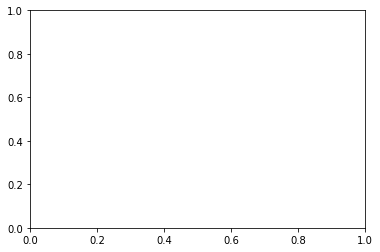

In [14]:
import pickle
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import StratifiedGroupKFold

# run classifier with k-flod cross validation and plot ROC curve
cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

# check score many model
score_lr = []
score_svm_l = []
score_svm_p = []
score_svm_r = []
score_rf = []

history_svm_l = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()

for i, (train, val) in enumerate(cv.split(X, y)):
    X_train, X_val = X[train], X[val]
    y_train, y_val = y[train], y[val]

    # fit model (try svm kernel = linear)
    clf = svm.SVC(kernel='linear', C=1, probability=True)
    clf.fit(X_train, np.ravel(y_train,order='C'))

    # save model
    with open('model/svm_l.pickle', 'wb') as f:
        pickle.dump(clf, f)

    # predict
    predict = clf.predict(X_val)
    clf_probs = clf.predict_proba(X_val)

    # store model report in history list
    history_svm_l.append(classification_report(y_val, predict))

    # get acc
    acc = accuracy_score(y_val, predict)

    print("test test test")

    # get loss ERROR
    loss = log_loss(y_val, clf_probs, zero_division=0)
    print(f"Fold {i + 1}")
    print(f"accuracy_score: {acc}")
    print(f"log_loss: {loss}")

    viz = plot_roc_curve(clf, X[val], y[val], name=f"ROC fold {i + 1}", alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=1, color="r", label="Chance", alpha=0.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [ ]:
'''
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
print(clf.score(X_val, y_val))

clf = svm.SVC(kernel='poly', C=1).fit(X_train, y_train)
print(clf.score(X_val, y_val))

clf = svm.SVC(kernel='rbf', C=1).fit(X_train, y_train)
print(clf.score(X_val, y_val))

lr = LogisticRegression()
lr.fit(X_train, y_train)
print(lr.score(X_val, y_val))

rf = RandomForestClassifier(n_estimators=40)
rf.fit(X_train, y_train)
print(rf.score(X_val, y_val))
'''

C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
